<a href="https://colab.research.google.com/github/antonpagel/Computational-Optimal-Transport/blob/main/Computational_Optimal_Transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Optimal Transport

## Histograms and Measures
We will call any element $a$ belonging to the probability simplex $Σ_n \overset{\text{def}}{=} \left\{ a \in \mathbb{R}_+^n \mid \sum_{i=1}^n a_i = 1 \right\}$ a histogram.

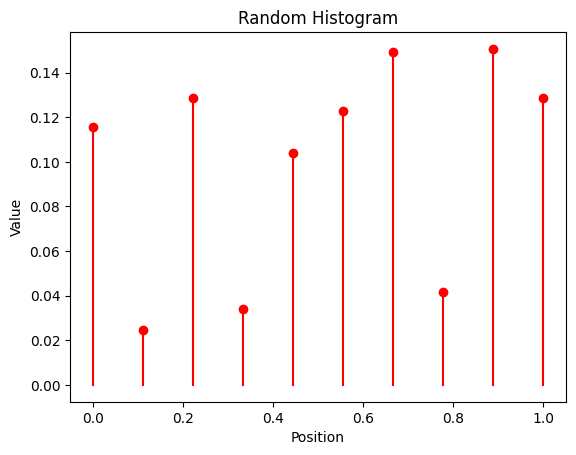

In [1]:
# @title A discrete Histogram
from matplotlib import pyplot as plt
import numpy as np

def showHistogram(a, title = "") :
    x = np.linspace(0, 1, len(a))
    for i, val in enumerate(a):
        plt.plot([x[i], x[i]], [0, val], color="red")
        plt.scatter(x[i], val, color="red")
    plt.title(title)
    plt.xlabel("Position")
    plt.ylabel("Value")
    plt.show()

a = np.random.rand(10)
a = a / np.sum(a)
showHistogram(a, "Random Histogram")

To be able to work with a positive, continous measure $α$, we will sample the measure with a given resolution $r$ and recive the histogram $a_i = \frac{α(x_i)}{\sum_i^r α(x_i)}$ using $x_i = \frac{i}{r}$.

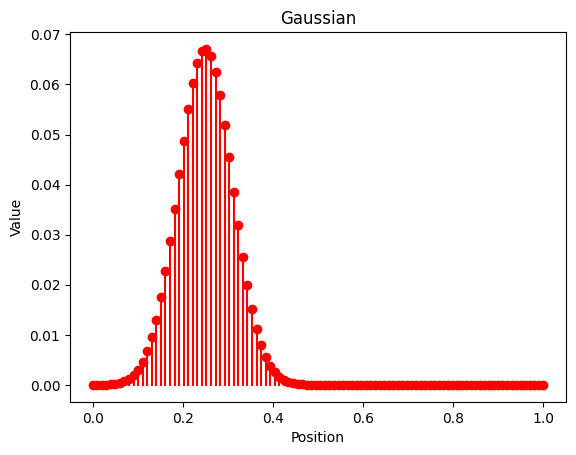

In [2]:
# @title Sampling a Gaussian
def gaussian(x, sigma, mu) :
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-.5 * ((x - mu) / sigma)**2)

def getHistogram(resolution, measure, proportionalMin = 0, **kwargs) :
    a = measure(np.linspace(0, 1, resolution), **kwargs)
    a += np.max(a) * proportionalMin
    return a / np.sum(a)

a = getHistogram(100, gaussian, **{"sigma" : .06, "mu" : .25})
showHistogram(a, "Gaussian")

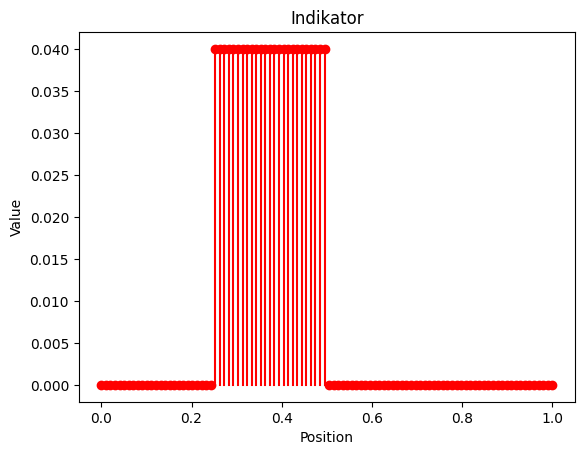

In [3]:
# @title Sampling an indikator function
def indikator(x, lowerBound, upperBound) :
    return [0 if p < lowerBound or upperBound < p else 1 for p in x]

b = getHistogram(100, indikator, **{"lowerBound" : .25, "upperBound" : .5})
showHistogram(b, "Indikator")

## The discrete Monge Problem
Given two histograms $a$ and $b$, the Monge problem seeks a map $T: \{x_1, \dots, x_n\} \to \{y_1, \dots, y_m\}$ that associates to each point $x_i$ one point $y_j$ and which verifies $∀ j = 1, \dots, m: b_j = \sum_{i: T(x_i) = y_j} a_i$. In this case we say that $T$ pushes the mass of $a$ towards the mass of $b$. \\
Such a map should minimize some transportation cost $c(x_i, y_j)$ of moving the mass from point $x_i$ to $y_j$, which is encoded by a cost matrix $(C_{i, j})_{i = 1, \dots, n \; j = 1, \dots, m}$. Monge's optimal transportation problem is defined as
$$\min_T \left\{ \sum_{i = 1, \dots, n} C_{i, j: T(x_i) = y_j} \mid T \text{ pushes } a \text{ towards } b \right\}.$$
We will take the squared distance $c(x_i, y_j) = {(x_i - y_j)}^2$ as our cost function.

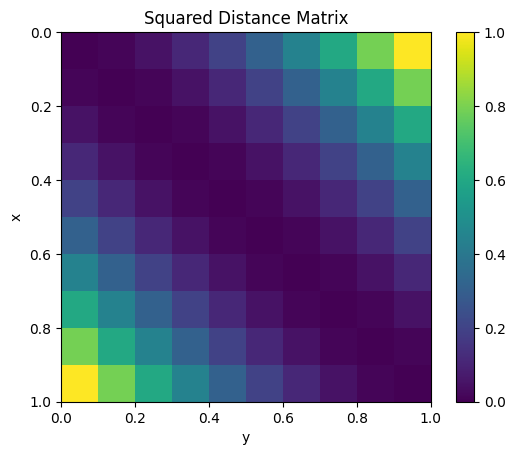

In [4]:
# @title Squared Distance Matrix as Cost Matrix
def getSquaredDistanceMatrix(n, m) :
    C = np.zeros((n, m))
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, m)

    for i in range(n) :
        for j in range(m) :
            C[i, j] = (x[i] - y[j])**2

    return C

def showMatrix(M, title = "") :
    plt.imshow(M, extent=[0, 1, 1, 0])
    plt.title(title)
    plt.colorbar();
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

C = getSquaredDistanceMatrix(10, 10)
showMatrix(C, "Squared Distance Matrix")

## Kantorovich Relaxation
The key idea is of Kantorovich is to relax the fact that a source $x_i$ can only be assinted to one location $y_j$. From now one we will stop using a map $T$ and focus on coupling matrices $P \in \mathbb{R}_+^{n \times m}$, where $P_{i, j}$ describes the ammount of mass flowing from $x_i$ towards $y_j$. The set of admissible couplings is $U(a, b) \overset{\text{def}}{=} \left\{ P \in \mathbb{R}_+^{n \times m} \mid P 1_m = a \text{ and } P^T 1_n = b \right\}$ and the Kantorovich's optimal transportation problem now reads
$$L_C(a, b) \overset{\text{def}}{=} \min_{P \in U(a, b)} ⟨C, P⟩ \overset{\text{def}}{=} \sum_{i, j} C_{i, j} P_{i, j}.$$

## Dual Problem
The Kantorovich problem can be naturally paired with the dual problem
$$L_C(a, b) = \max_{(f, g) \in R(C)} ⟨f, a⟩ + ⟨g, b⟩,$$
where the set of admissible dual variables is defined as
$$R(C) \overset{\text{def}}{=} \left\{(f, g) \in \mathbb{R}^n × \mathbb{R}^m \mid ∀ (i, j) \in \{1, \dots, n\} × \{1, …, m\}: f_i + g_j \leq C_{i, j} \right\}.$$

## Entropic Regularization
The discrete entropy of a coupling matrix $P$ is defined as
$$H(P) \overset{\text{def}}{=} - \sum_{i, j} P_{i, j} (\log(P_{i, j}) - 1).$$

## Sinkhorn's Algorithm
$$u^{(l+1)} \overset{\text{def}}{=} \frac{a}{K v^{(l)}} \text{ and } v^{(l+1)} \overset{\text{def}}{=} \frac{b}{K^T u^{(l+1)}}$$

Convergence in 64 steps.


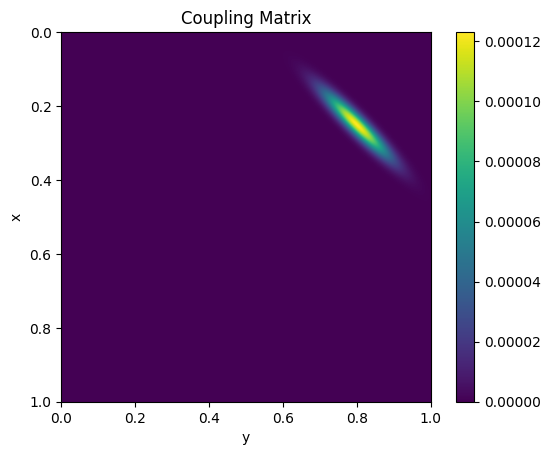

In [5]:
# @title Sinkhorn's Algorithm applied on two Gaussians
# @markdown Change the resolution.
resolution = 1000 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}

def plotConvergence(err) :
    plt.plot(np.log10(err[err.astype(bool)]), linewidth = 2)
    plt.title("Convergence")
    plt.xlabel("Step")
    plt.ylabel("Log Error")
    plt.show()

def sinkhorn(a, b, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    v = np.ones_like(b)
    u = np.zeros_like(a)

    errB = np.zeros(lMax)

    for l in range(lMax) :
        u = a / np.dot(K, v)
        r = np.dot(np.dot(np.diag(v), np.transpose(K)), u)
        errB[l] = np.linalg.norm((r - b), 1) / len(b)

        v = b / np.dot(np.transpose(K), u)
        if errB[l] < errMax :
            print("Convergence in", l, "steps.")
            break

    return np.dot(np.diag(u), np.dot(K, np.diag(v))), errB

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    showHistogram(a, "Histogram a")
    showHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = sinkhorn(a, b, C, eps, 1e-6, 1000)
showMatrix(P, "Coupling Matrix")

if showConv :
    plotConvergence(err)

Convergence in 64 steps.


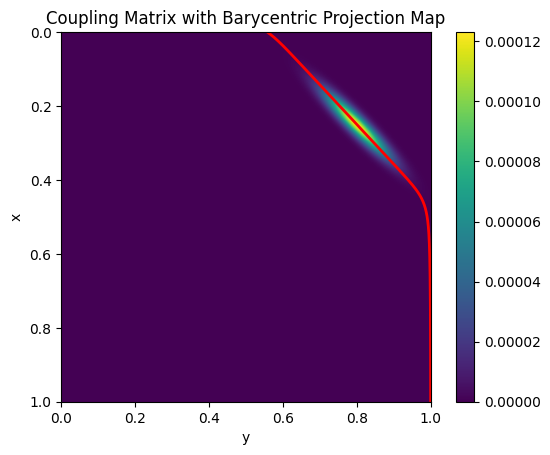

In [6]:
# @title View coupling matrix together with barycentric projection map
# @markdown Change the resolution.
resolution = 1000 # @param ["10","100","1000"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}

def showMatrixBarycentricProjection(P, resolution, title = "") :
    t = np.linspace(0, 1, resolution)
    s = np.array([])
    for i in range(0, resolution) :
        s = np.append(s, np.sum(np.dot(P[i, :], t)) / np.sum(P[i, :]))

    plt.imshow(P, extent=[0, 1, 1, 0])
    plt.plot(s, t, "r", linewidth=2)
    plt.title(title)
    plt.colorbar();
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    showHistogram(a, "Histogram a")
    showHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = sinkhorn(a, b, C, eps, 1e-6, 1000)

showMatrixBarycentricProjection(P, resolution, "Coupling Matrix with Barycentric Projection Map")

## Sinkhorn"s Algorithm in the Log-Domain
$\DeclareMathOperator{\Min}{Min}$
$$f^{(l+1)} = \Min_\varepsilon^\text{row}(C - 1_n {g^{(l)}}^T) + ɛ \log a \text{ and } g^{(l+1)} = \Min_ɛ^\text{col}(C - f^{(l)} {1_m}^T) + ɛ \log b$$

Convergence in 64 steps.


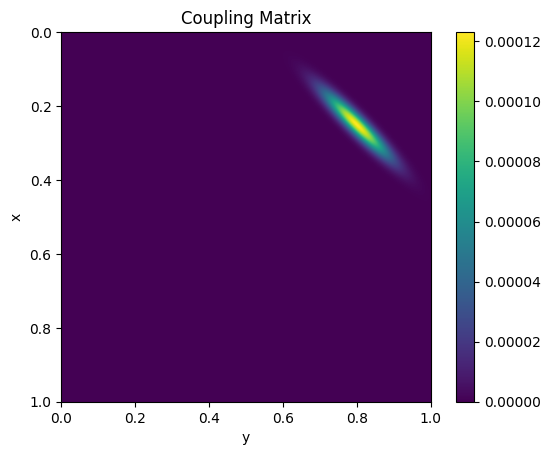

In [7]:
# @title Sinkhorn's Algorithm applied on two Gaussians in the Log-Domain
# @markdown Change the resolution.
resolution = 1000 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}

def softMin(z, eps) :
    return -eps * np.log(np.sum(np.exp(-z / eps)))

def minRow(A, eps) :
    return np.apply_along_axis((lambda z : softMin(z, eps)), 1, A)

def minCol(A, eps) :
    return np.apply_along_axis((lambda z : softMin(z, eps)), 0, A)

def S(C, f, g) :
    return C - np.outer(f, np.ones_like(f)) - np.outer(np.ones_like(g), g)

def logSinkhorn(a, b, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    f = np.zeros_like(a)
    g = np.zeros_like(b)

    errA = np.zeros(lMax)

    for l in range(lMax) :
        f = minRow(S(C, f, g), eps) + f + eps * np.log(a)
        g = minCol(S(C, f, g), eps) + g + eps * np.log(b)

        P = np.exp((np.outer(f, np.ones_like(f)) - C + np.outer(np.ones_like(g), g)) / eps)

        s = np.dot(P, np.ones_like(a))
        r = np.dot(np.transpose(P), np.ones_like(b))
        errA[l] = np.linalg.norm((s - a), 1) / len(a)
        if errA[l] < errMax :
            print("Convergence in", l, "steps.")
            break

    return P, errA

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

if showHist :
    showHistogram(a, "Histogram a")
    showHistogram(b, "Histogram b")

C = getSquaredDistanceMatrix(resolution, resolution)

P, err = logSinkhorn(a, b, C, eps, 1e-6, 1000)
showMatrix(P, "Coupling Matrix")

if showConv :
    plotConvergence(err)

## Optimal Transport Barycenters
$\forall s \in \{1, \dots S\}: v_s^{(l+1)} = \frac{b_s}{K^T u_s^{(l)}}$ and $\forall s \in \{1, \dots, S\}: u_s^{(l+1)} = \frac{a^{(l)}}{K v_s^{(l+1)}}$ where $a^{(l)} = \prod_{s=1}^S ( u_s^{(l)} \odot (K v_s^{(l+1)}))$

### One Dimensional

Convergence in 261 steps.


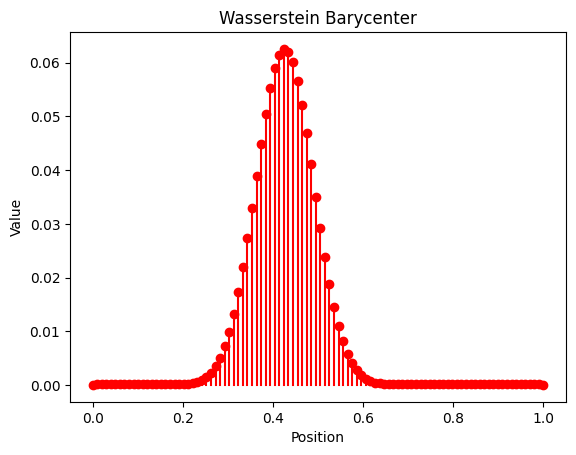

In [8]:
from binascii import b2a_base64
# @title Wasserstein Barycenter of two Gaussians
# @markdown Change the resolution.
resolution = 100 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}
# @markdown Select the weights.
lambda2 = 0.32 # @param {"type":"slider","min":0,"max":1,"step":0.01}

def barycenter(b1, b2, res, lambd, C, eps, errMax, lMax) :
    K = np.exp(-C / eps)
    S = 2

    B = np.zeros([res, S])
    B[:, 0] = b1
    B[:, 1] = b2

    U = np.ones([res, S])
    V = np.zeros([res, S])

    err = np.zeros([lMax, S])

    a = np.ones(res)

    for l in range(lMax) :
        for s in range(S) :
            V[:, s] = B[:, s] / np.dot(np.transpose(K), U[:, s])

        a = np.ones(res)
        for s in range(S) :
            a = a * (U[:, s] * np.dot(K, V[:, s]))**lambd[s]

        for s in range(S) :
            U[:, s] = a / np.dot(K, V[:, s])
            r = np.dot(np.dot(np.diag(V[:, s]), np.transpose(K)), U[:, s])
            err[l, s] = np.linalg.norm((r - B[:, s]), 1) / res

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    P = np.zeros([res, res, S])

    for s in range(S) :
        P[:, :, s] = np.dot(np.diag(U[:, s]), np.dot(K, np.diag(V[:, s])))

    return P, a, err

b1 = getHistogram(resolution, gaussian, .001, **{"sigma" : .06, "mu" : .25})
b2 = getHistogram(resolution, gaussian, .001, **{"sigma" : .06, "mu" : .8})

C = getSquaredDistanceMatrix(resolution, resolution)

P, a, err = barycenter(b1, b2, resolution, np.array([1-lambda2, lambda2]), C, eps, 1e-8, 1000)

if showHist :
    showHistogram(b1, "First Histogram")
    showHistogram(b2, "Second Histogram")

showHistogram(a, "Wasserstein Barycenter")

if showConv :
    plotConvergence(err[:, 0])
    plotConvergence(err[:, 1])

Convergence in 121 steps.


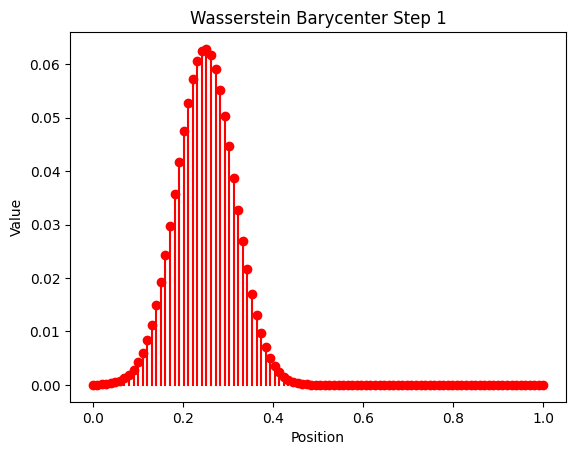

Convergence in 116 steps.


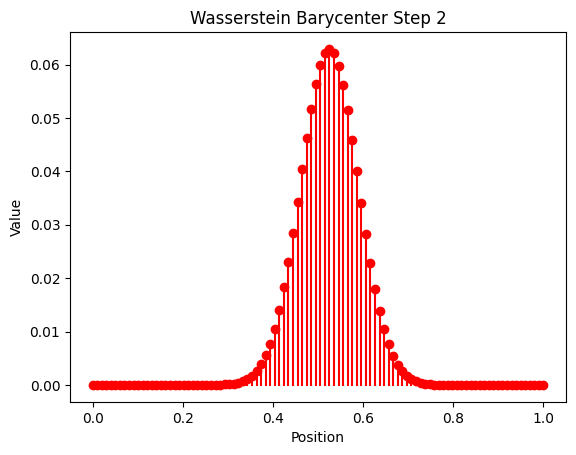

Convergence in 121 steps.


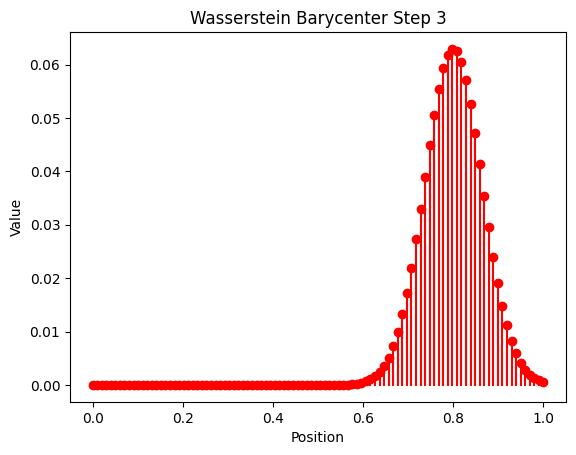

In [9]:
# @title Wasserstein Barycenter of two Gaussians in $n$ Steps
# @markdown Change the resolution.
resolution = 100 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 3 # @param {"type":"integer"}

b1 = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
b2 = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .8})

C = getSquaredDistanceMatrix(resolution, resolution)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter(b1, b2, resolution, lambd, C, eps, 1e-8, 1000)
    showHistogram(a, "Wasserstein Barycenter Step " + str(i+1))

### Two Dimensional

Saving pacman1.bmp to pacman1.bmp
Saving pacman2.bmp to pacman2.bmp


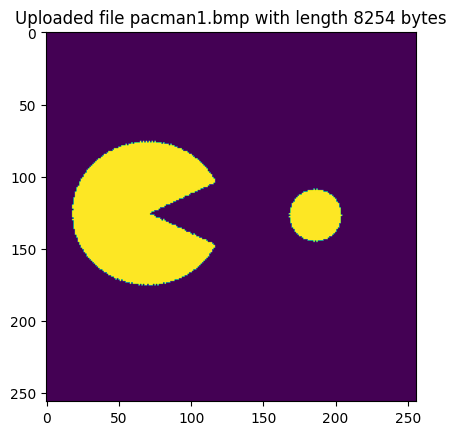

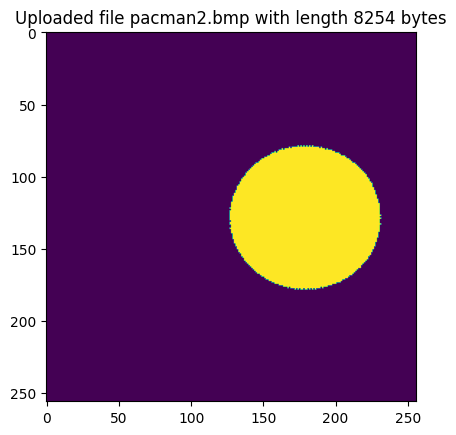

In [ ]:
# @title Upload Files

from google.colab import files
from matplotlib import pyplot as plt
import numpy as np
import cv2

def showImage(img, title = "") :
    plt.imshow(img)
    plt.title(title)
    plt.show()

uploaded = files.upload()

for fn in uploaded.keys() :
    showImage(cv2.imread(fn, cv2.IMREAD_GRAYSCALE), "Uploaded file {name} with length {length} bytes".format(name=fn, length=len(uploaded[fn])))

Convergence in 699 steps.


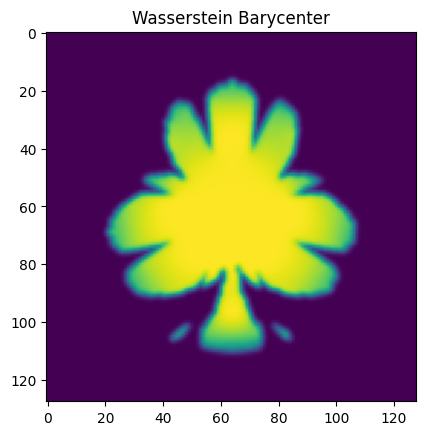

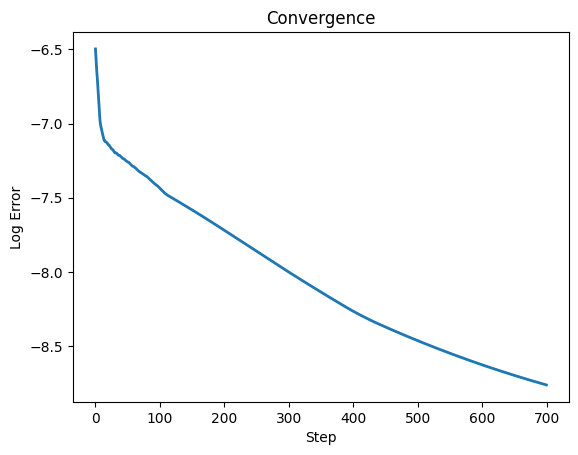

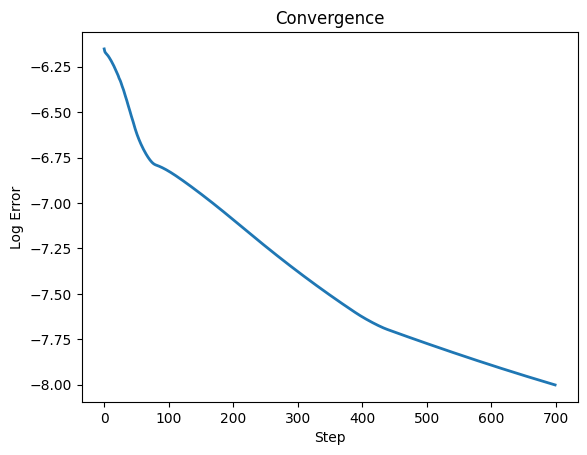

In [ ]:
# @title Two Dimensional Wasserstein Barycenter
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-4 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Show the histograms.
showHist = False # @param {type:"boolean"}
# @markdown Show the convergence.
showConv = False # @param {type:"boolean"}
# @markdown Select the weights.
lambda2 = 0.21 # @param {"type":"slider","min":0,"max":1,"step":0.01}

def getKernelAsFunc(X, Y, eps) :
    K1 = np.exp(-(X-Y)**2/eps)
    K = lambda x: np.dot(np.dot(K1,x),K1)
    return K

def getImageAsHistogram(fn, res, min) :
    img = cv2.resize(cv2.imread(fn, cv2.IMREAD_GRAYSCALE), (res, res), interpolation=cv2.INTER_NEAREST)
    img = (img + .01) / np.sum(img + .01)
    return img

def barycenter2d(b1, b2, res, lambd, eps, errMax, lMax) :
    [X, Y] = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    K = getKernelAsFunc(X, Y, eps)
    S = 2

    B = np.zeros([res, res, S])
    B[:, :, 0] = b1
    B[:, :, 1] = b2

    err = np.zeros([lMax, S])

    U = np.ones([res, res, S])
    V = np.zeros([res, res, S])

    a = np.ones([res, res])

    for l in range(lMax) :
        for s in range(S) :
            V[:, :, s] = B[:, :, s] / K(U[:, :, s])

        a = np.zeros([res, res])
        for s in range(S) :
            a = a + np.log(np.maximum(1e-19*np.ones([res, res]), U[:, :, s]*K(V[:, :, s]))) * lambd[s]

        a = np.exp(a)

        for s in range(S) :
            U[:, :, s] = a / K(V[:, :, s])
            r = V[:, :, s] * K(U[:, :, s])
            err[l, s] = np.linalg.norm(r - B[:, :, s], 1) / (res**2)

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    P = np.zeros([res, res, res, res, S])

    for s in range(S) :
        P[:, :, :, :, s] = np.dot(np.diag(U[:, :, s]), K(V[:, :, s]))

    return P, a, err

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)

if showHist :
    showImage(b1, "Clover")
    showImage(b2, "Star")

P, a, err = barycenter2d(b1, b2, resolution, np.array([1-lambda2, lambda2]), eps, 1e-9, 3000)

showImage(a, "Wasserstein Barycenter")

if showConv :
    plotConvergence(err[:, 0])
    plotConvergence(err[:, 1])

Convergence in 206 steps.


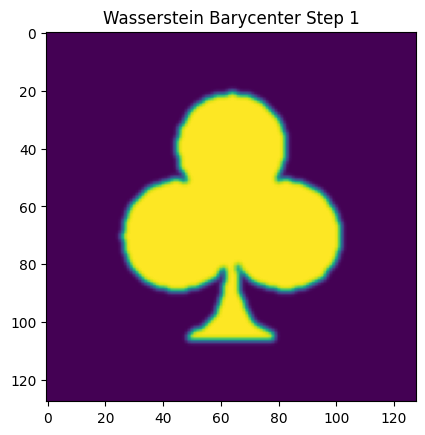

Convergence in 160 steps.


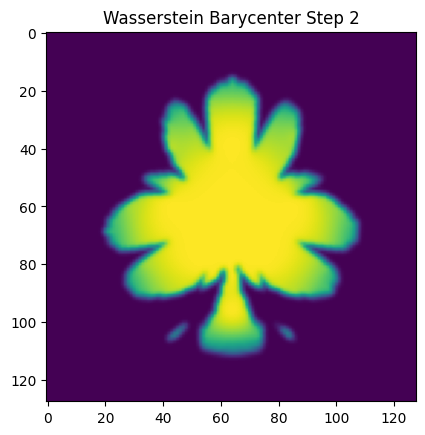

Convergence in 89 steps.


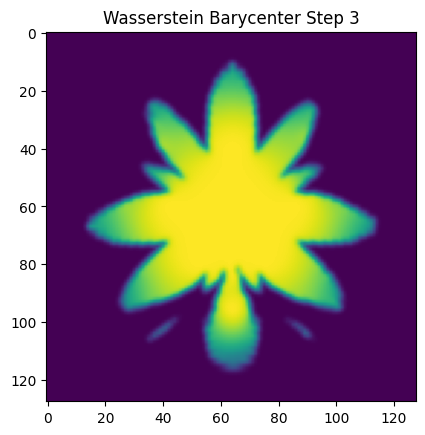

Convergence in 134 steps.


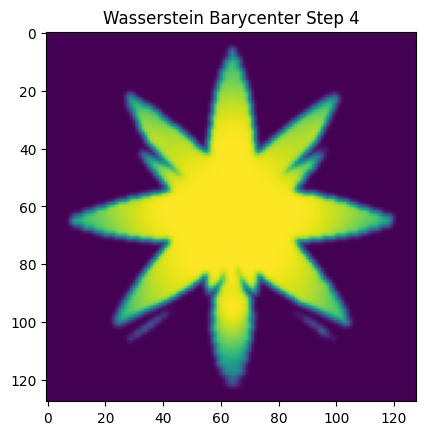

Convergence in 176 steps.


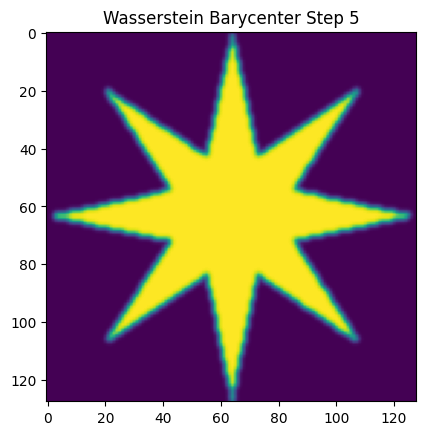

In [ ]:
# @title Two Dimensional Wasserstein Barycenter in $n$ Steps
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-4 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 5 # @param {"type":"integer"}

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter2d(b1, b2, resolution, lambd, eps, 1e-7, 3000)
    showImage(a, "Wasserstein Barycenter Step " + str(i+1))

Convergence in 193 steps.


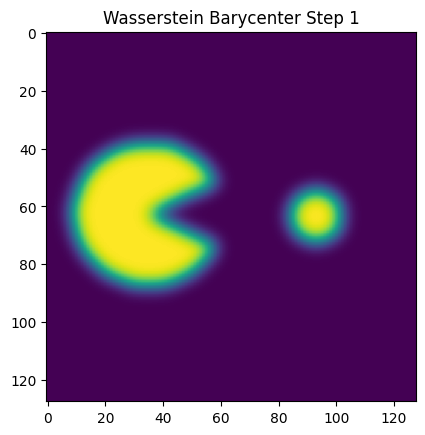

Convergence in 181 steps.


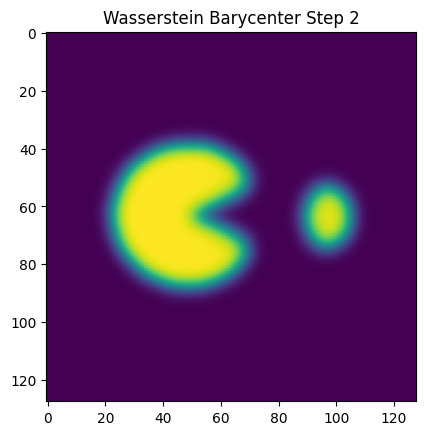

Convergence in 163 steps.


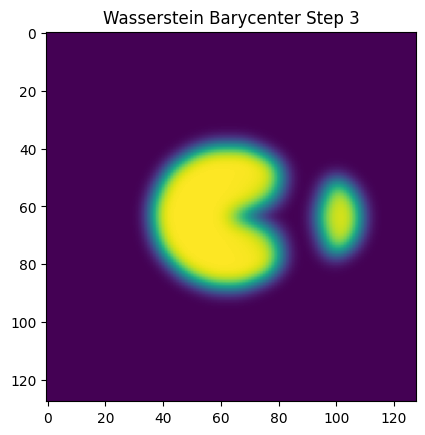

Convergence in 160 steps.


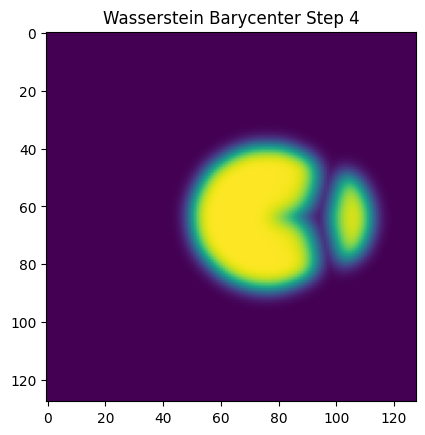

Convergence in 176 steps.


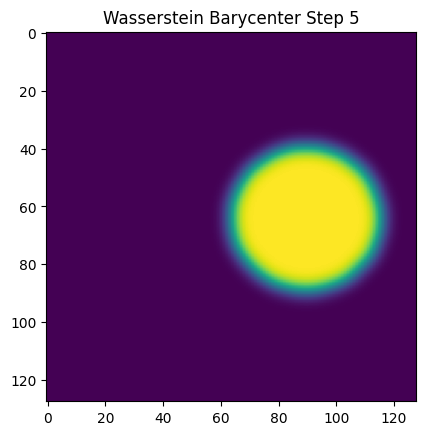

In [ ]:
# @title Pacman
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}
# @markdown Number of steps.
steps = 5 # @param {"type":"integer"}

b1 = getImageAsHistogram("pacman1.bmp", resolution, .01)
b2 = getImageAsHistogram("pacman2.bmp", resolution, .01)

for i in range(steps) :
    l = i/(steps-1)
    lambd = np.array([1-l, l])
    P, a, err = barycenter2d(b1, b2, resolution, lambd, eps, 1e-7, 3000)
    showImage(a, "Wasserstein Barycenter Step " + str(i+1))

In [ ]:
# @title Triangle
# @markdown Change the resolution.
resolution = 128 # @param ["32","64","128","256"] {"type":"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-3 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6"] {type:"raw"}

def barycenter2d3hist(b1, b2, b3, res, lambd, eps, errMax, lMax) :
    [X, Y] = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
    K = getKernelAsFunc(X, Y, eps)
    S = 3

    B = np.zeros([res, res, S])
    B[:, :, 0] = b1
    B[:, :, 1] = b2
    B[:, :, 2] = b3

    err = np.zeros([lMax, S])

    U = np.ones([res, res, S])
    V = np.zeros([res, res, S])

    a = np.ones([res, res])

    for l in range(lMax) :
        for s in range(S) :
            V[:, :, s] = B[:, :, s] / K(U[:, :, s])

        a = np.zeros([res, res])
        for s in range(S) :
            a = a + np.log(np.maximum(1e-19*np.ones([res, res]), U[:, :, s]*K(V[:, :, s]))) * lambd[s]

        a = np.exp(a)

        for s in range(S) :
            U[:, :, s] = a / K(V[:, :, s])
            r = V[:, :, s] * K(U[:, :, s])
            err[l, s] = np.linalg.norm(r - B[:, :, s], 1) / (res**2)

        if np.max(err[l, :]) < errMax :
            print("Convergence in", l, "steps.")
            break

    return a, err

b1 = getImageAsHistogram("clover.bmp", resolution, .01)
b2 = getImageAsHistogram("star.bmp", resolution, .01)
b3 = getImageAsHistogram("cat.bmp", resolution, .01)

Lambd = np.zeros([3, 15])
Lambd[:, 0] = np.array([0, 0, 1])
Lambd[:, 1] = np.array([1, 0, 3])
Lambd[:, 2] = np.array([0, 1, 3])
Lambd[:, 3] = np.array([1, 0, 1])
Lambd[:, 4] = np.array([1, 1, 2])
Lambd[:, 5] = np.array([0, 1, 1])
Lambd[:, 6] = np.array([3, 0, 1])
Lambd[:, 7] = np.array([2, 1, 1])
Lambd[:, 8] = np.array([1, 2, 1])
Lambd[:, 9] = np.array([0, 3, 1])
Lambd[:, 10] = np.array([1, 0, 0])
Lambd[:, 11] = np.array([3, 1, 0])
Lambd[:, 12] = np.array([1, 1, 0])
Lambd[:, 13] = np.array([1, 3, 0])
Lambd[:, 14] = np.array([0, 1, 0])

for i in range(Lambd.shape[1]) :
    Lambd[:, i] = Lambd[:, i] / np.sum(Lambd[:, i])
    a, err = barycenter2d3hist(b1, b2, b3, resolution, Lambd[:, i], eps, 1e-9, 3000)
    showImage(a, "Wasserstein Barycenter")

In [ ]:
# @title Playground 1
# @markdown Change the resolution.
resolution = 100 # @param ["10", "100", "1000"] {type:"raw"}
# @markdown Change the value of $\varepsilon$.
eps = 1e-5 # @param ["1", "1e-1", "1e-2", "1e-3", "1e-4", "1e-5", "1e-6", "1e-10"] {type:"raw"}
# @markdown Show the histograms.
show = True # @param {type:"boolean"}

def addHistograms(a, b) :
    return (a + b) / np.sum(a + b)

a = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .5})
b = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .25})
c = getHistogram(resolution, gaussian, **{"sigma" : .06, "mu" : .75})
d = addHistograms(b, c)

if show :
    showHistogram(a, "Histogram a")
    showHistogram(d, "Histogram d")

C = getSquaredDistanceMatrix(resolution, resolution)

P = logSinkhorn(a, d, C, eps, 1e-5, 1000)
showMatrix(P, "Coupling Matrix")
showMatrixBarycentricProjection(P, resolution, "Coupling Matrix with Barycentric Projection Map")